<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/reconstruct_3d.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/reconstruct_3d.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to stack together multiple 2D H&E images to 3D stack

In [1]:
# @title Inputs

# Define output volume
x_range_mm = [-1, 1]
y_range_mm = [-1, 1]
pixel_size_mm = 1e-3 # 1 micron is 1e-3

# Define input planes
plane_inputs = []

plane_inputs.append({
    "uv_pix": [[0,0],[100,0],[0,100]],
    "xyz_mm": [[0,0,0],[1,0,0],[0,1,0]],
    "image_file_path": "red.png"
})
plane_inputs.append({
    "uv_pix": [[0,1000],[1000,1000],[0,2000]],
    "xyz_mm": [[0,0,0.002],[1,0,0.002],[0,1,0.002]],
    "image_file_path": "0000.tif"
})
plane_inputs.append({
    "uv_pix": [[0,100],[100,100],[0,200]],
    "xyz_mm": [[0,0,0.008],[1,0,0.008],[0,1,0.008]],
    "image_file_path": "blue.png"
})

In [2]:
# @title Environment Setup

from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np
import cv2
from PIL import Image

%cd ..

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'coregister-xy' already exists and is not an empty directory.
/content/coregister-xy
/content


In [3]:
import tifffile

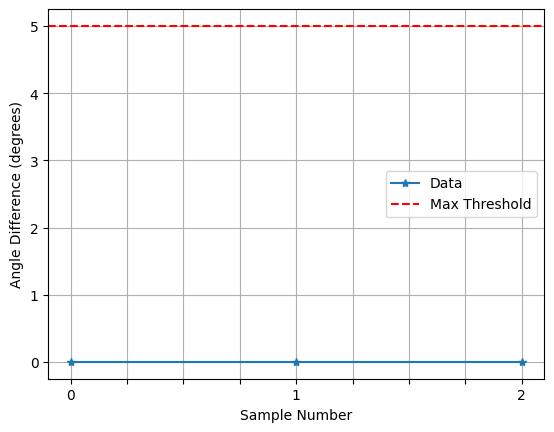

In [4]:
# @title Fit planes

# Fit individual planes
fps = []
for plane_input in plane_inputs:
  fp = FitPlane.from_template_centers(plane_input['uv_pix'],plane_input['xyz_mm'])
  fps.append(fp)

# Find average normal to all
group_normal = np.array([0,0,0])
for fp in fps:
  group_normal = group_normal + fp.normal_direction()
group_normal = group_normal / np.linalg.norm(group_normal)

# Plot differences from the normal
normal_diff_angle_deg = []
for fp in fps:
  normal_diff_angle_deg.append(np.arccos(np.dot(fp.normal_direction(),group_normal))*180/np.pi)
plt.plot(normal_diff_angle_deg, '-*', label='Data')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '%d' % val if val % 1 == 0 else ''))
plt.xlabel('Sample Number')
plt.ylabel('Angle Difference (degrees)')
plt.grid(True)
plt.axhline(y=5, color='r', linestyle='--', label='Max Threshold')
plt.legend()
plt.show()

# Fit individual planes while considering the overall normal
fps2 = []
for plane_input in plane_inputs:
  fp = FitPlane.from_template_centers(
      plane_input['uv_pix'],plane_input['xyz_mm'],
      forced_plane_normal = group_normal)
  fps2.append(fp)

In [7]:
# @title Construct the 3D volume

# Obtain planes images
img_crops = []
image_distances_mm = []
for fp, plane_input in zip(fps2,plane_inputs):
  # Load image and project to the common space
  img = cv2.imread(plane_input["image_file_path"], cv2.IMREAD_COLOR)
  img_crop  = fp.image_to_physical(img, x_range_mm, y_range_mm, pixel_size_mm)
  img_crops.append(img_crop)

  # Store the distance
  image_distances_mm.append(fp.distance_from_origin_mm())
image_distances_mm = np.array(image_distances_mm)

# Build Tiff
empty_crop = np.zeros_like(img_crops[0])
z_min = np.min(image_distances_mm)
z_max = np.max(image_distances_mm)
tiff_stack = []
for z in np.arange(z_min, z_max, pixel_size_mm):
  # Find the closest fp
  diffs = np.abs(image_distances_mm - z)
  min_diff = np.min(diffs)
  min_index = np.argmin(diffs)

  if min_diff < 5e-3/2: # Less than thickness of a slide, use this image
    t = img_crops[min_index]
  else:
    t = empty_crop

  tiff_stack.append(Image.fromarray(cv2.cvtColor(t, cv2.COLOR_BGR2RGB)))

print(len(tiff_stack), " images in stack")

tiff_stack = np.array(tiff_stack).astype(np.uint8)

tifffile.imwrite(
     'output_multipage.tiff',
     tiff_stack,
     bigtiff=True,
     resolution=(10 / pixel_size_mm, 10 / pixel_size_mm),
     resolutionunit='centimeter',
 )

9  images in stack


In [8]:
# @title Save file to computer
from google.colab import files
print('Open the File in ImageJ!')
files.download("output_multipage.tiff")

Open the File in ImageJ!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>